# Data for CSCI 7000 final

## Imports

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
import multiprocessing as mp
import itertools
import plotly.express as px
from scipy.stats import entropy
from functools import partial
import re
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
import random

## Data

In [44]:
os.chdir("/data/jake/csci_7000-final_project")
print(os.getcwd(), os.listdir())

/data/jake/csci_7000-final_project ['csci_7000-genes.tsv', '1kg-g2g_train.pth', '1kg-g2g_vecs.tsv', 'test.tsv', 'fig', '1kg-g2g_l2.tsv', '1kg-g2g-tensors.pt', '1kg-g2g_l2-jl.tsv', 'csci_7000-gene_subsetting.ipy', '1kg-g2g_kl.tsv', 'data.ipynb', 'samples_1kg', 'train.ipynb', 'gargs.log']


In [45]:
# all 1kg giggle files
giggle_1kg = "/data/jake/genefusion/data/2024_11_01-fusions-1kg/giggle"
os.listdir(giggle_1kg)[:5]

['1.pos.CCDC28B.32665987.32670988.giggle',
 '2.pos.AC074117.10.27579113.27590489.giggle',
 '3.pos.CRELD1.9975506.9987097.giggle',
 '1.neg.IVNS1ABP.185265520.185286461.giggle',
 '16.neg.NPIPB7.28467693.28481868.giggle']

### Gene list

- See ipy file for subset heuristic

In [22]:
df = pd.read_csv("./csci_7000-genes.tsv", sep="\t", header=None)
df.columns = ["gene1", "gene2"]
df.head()

,gene1,gene2
0,TNRC6B,LRP1B
1,TNRC6B,ASH1L
2,TNRC6B,IQCJnegSCHIP1
3,TNRC6B,CACNA1E
4,TNRC6B,KIAA1671


In [23]:
genes = set(pd.concat([df["gene1"], df["gene2"]]).unique())

In [24]:
def filestring2data(string):
    # assumes .giggle extension
    chrm = string.split(".")[0]
    strand = string.split(".")[1]
    gene = string.split(".")[2]
    start = string.split(".")[-3]
    end = string.split(".")[-2]
    # handle rare case where gene name has a period
    if len(string.split(".")) >= 7:
        gene = ".".join(string.split(".")[2:-3])
    return [chrm, strand, gene, start, end]

In [25]:
filestring2data("21.neg.AP000304.12.34956993.35284635.giggle")

['21', 'neg', 'AP000304.12', '34956993', '35284635']

### Gene giggles

In [26]:
# map genes to giggle files
fmap = {k: None for k in genes}
for f in os.listdir(giggle_1kg):
    _, _, gene, _, _ = filestring2data(f)
    if gene in fmap.keys():
        fmap[gene] = f

In [27]:
list(fmap.items())[0:5]

[('TSHZ2', '20.pos.TSHZ2.51588946.52111869.giggle'),
 ('AGAP1', '2.pos.AGAP1.236402733.237040444.giggle'),
 ('EIF2B5', '3.pos.EIF2B5.183852826.184402546.giggle'),
 ('EVI5', '1.neg.EVI5.92974253.93257961.giggle'),
 ('TBC1D5', '3.neg.TBC1D5.17198654.18486309.giggle')]

In [28]:
df_fmap = pd.DataFrame(list(fmap.items()), columns=["gene", "file"])
df_fmap.head()

,gene,file
0,TSHZ2,20.pos.TSHZ2.51588946.52111869.giggle
1,AGAP1,2.pos.AGAP1.236402733.237040444.giggle
2,EIF2B5,3.pos.EIF2B5.183852826.184402546.giggle
3,EVI5,1.neg.EVI5.92974253.93257961.giggle
4,TBC1D5,3.neg.TBC1D5.17198654.18486309.giggle


In [120]:
df_giggle = pd.read_csv(
    os.path.join(giggle_1kg, df_fmap["file"][0]), sep="\t", header=None
)
giggle_columns = [
    "l_chrm",
    "l_start",
    "l_end",
    "strand",
    "r_chrm",
    "r_start",
    "r_end",
    "strand",
    "unknown",
    "sample",
]
df_giggle.columns = giggle_columns
df_giggle.head()

,l_chrm,l_start,l_end,strand,r_chrm,r_start,r_end,strand,unknown,sample
0,1,12315035,12315134,-1,5,13507894,13507973,-1,0,alt_sort/HG00096.bed.gz
1,1,12344923,12345023,-1,7,2018079,2018178,-1,0,alt_sort/HG00096.bed.gz
2,1,12386032,12386131,-1,5,22740652,22740752,1,0,alt_sort/HG00096.bed.gz
3,1,12433155,12433190,-1,18,4705296,4705395,-1,0,alt_sort/HG00096.bed.gz
4,1,12477324,12477423,1,1,12477548,12477648,-1,0,alt_sort/HG00096.bed.gz


In [121]:
# read giggle if not empty
def read_giggle(path):
    # handle empty file case for lexicographically high ranked files
    # which are often right intervals
    # thus, no giggle hits when it is query/source
    if not (os.path.getsize(path) == 0):
        df = pd.read_csv(path, sep="\t", header=None)
        df.columns = [
            "l_chrm",
            "l_start",
            "l_end",
            "strand",
            "r_chrm",
            "r_start",
            "r_end",
            "strand",
            "unknown",
            "sample",
        ]
        return df
    else:
        return None


df_giggle = read_giggle(os.path.join(giggle_1kg, df_fmap["file"][0]))
df_giggle.head()

,l_chrm,l_start,l_end,strand,r_chrm,r_start,r_end,strand,unknown,sample
0,1,12315035,12315134,-1,5,13507894,13507973,-1,0,alt_sort/HG00096.bed.gz
1,1,12344923,12345023,-1,7,2018079,2018178,-1,0,alt_sort/HG00096.bed.gz
2,1,12386032,12386131,-1,5,22740652,22740752,1,0,alt_sort/HG00096.bed.gz
3,1,12433155,12433190,-1,18,4705296,4705395,-1,0,alt_sort/HG00096.bed.gz
4,1,12477324,12477423,1,1,12477548,12477648,-1,0,alt_sort/HG00096.bed.gz


In [17]:
# setup outdir for giggle subset
outdir = "/data/jake/csci_7000-final_project/samples_1kg/giggle"

In [123]:
def write_giggle(df, path, mode="a"):
    df.to_csv(path, sep="\t", index=False, header=False, mode=mode)


write_giggle(df_giggle, "test.tsv")

### Sample-wise giggles

In [16]:
def split_giggle_samples(file):
    gene = filestring2data(file)[2]
    path = os.path.join(giggle_1kg, file)
    df_giggle = read_giggle(path)
    if type(df_giggle) != type(None):
        df_giggle["sample"] = df_giggle["sample"].apply(
            lambda x: os.path.basename(x).split(".")[0]
        )
        # print(df_giggle['sample'])
        for sample, group in df_giggle.groupby("sample"):
            write_giggle(group, os.path.join(outdir, f"{sample}.{gene}.tsv"), mode="w")


# files = list(df_fmap["file"])
# cpus = 50
# with mp.Pool(cpus) as pool:
#     pool.map(split_giggle_samples, files)

### Intersect

- Group by sample
- Write sample-wise results to files
    - `split_giggle_samples`
- Do intersect for gene2gene variants
    - `genefile='/data/jake/genefusion/data/gene_file_cln.txt'`
    - `outdir=''`
    - `bedtools=''`
    - `ls | gargs --log ../gargs.log -p 64 -o "$bedtools intersect -a $genefile -b <(cut -f 5-7 {0}) > $outdir/{0}.g2g"`

- Convert fusion results to vector

In [13]:
dir_g2g_1kg = "/data/jake/csci_7000-final_project/samples_1kg/gene2gene"

In [14]:
os.listdir(dir_g2g_1kg)[:5]

['NA18614.CSMD2.tsv.fusions',
 'HG01918.CTNNA2.tsv.fusions',
 'NA18546.DCC.tsv.fusions',
 'HG02855.RBMS3.tsv.fusions',
 'HG03565.CPNE4.tsv.fusions']

In [15]:
def read_gene2gene(file):
    df = pd.read_csv(file, sep="\t", header=None, usecols=[3])
    df.columns = ["target"]
    return df


read_gene2gene(os.path.join(dir_g2g_1kg, "HG00096.ALK.tsv.fusions")).head()

,target
0,RP11neg611E13.2
1,RP11neg611E13.2
2,DLEU7
3,DLEU7negAS1
4,ATP1A3


### Location map

In [8]:
gene_file = "/data/jake/genefusion/data/gene_file_cln.txt"
df_gene_file = pd.read_csv(gene_file, sep="\t", header=None)
df_gene_file.columns = ["chrm", "start", "end", "gene", "strand"]
df_gene_file.head()

,chrm,start,end,gene,strand
0,1,69091,70008,OR4F5,pos
1,1,134901,139379,AL627309.1,neg
2,1,139790,140339,RP11neg34P13.14,neg
3,1,367640,368634,OR4F29,pos
4,1,621059,622053,OR4F16,neg


In [9]:
# subset
mask = df_gene_file["gene"].apply(lambda x: x in genes)
df_gene_file = df_gene_file[mask]
df_gene_file.head()

,chrm,start,end,gene,strand
145,1,6845384,7829766,CAMTA1,pos
159,1,8412457,8877702,RERE,neg
227,1,12290124,12572099,VPS13D,pos
261,1,14925200,15444539,KAZN,pos
308,1,17066768,17299474,CROCC,pos


- the gene file is already lexicographically sorted for chromosomes
- a second and thrid level sorts by start and end coordinates

In [10]:
g2g_comb = list(itertools.combinations(df_gene_file["gene"].tolist(), 2))
g2g_comb = pd.DataFrame(g2g_comb)
g2g_comb.columns = ["source", "target"]
g2g_comb

,source,target
0,CAMTA1,RERE
1,CAMTA1,VPS13D
2,CAMTA1,KAZN
3,CAMTA1,CROCC
4,CAMTA1,EIF4G3
...,...,...
18716,ARHGAP6,IL1RAPL1
18717,ARHGAP6,DMD
18718,FRMPD4,IL1RAPL1
18719,FRMPD4,DMD


### Vectorize samples

In [11]:
def init_vector(g2g_comb):
    return pd.Series(
        np.zeros(g2g_comb.shape[0], dtype=np.int64),
        index=g2g_comb.apply(lambda row: f"{row['source']}-{row['target']}", axis=1),
    )


init_vector(g2g_comb)

CAMTA1-RERE         0
CAMTA1-VPS13D       0
CAMTA1-KAZN         0
CAMTA1-CROCC        0
CAMTA1-EIF4G3       0
                   ..
ARHGAP6-IL1RAPL1    0
ARHGAP6-DMD         0
FRMPD4-IL1RAPL1     0
FRMPD4-DMD          0
IL1RAPL1-DMD        0
Length: 18721, dtype: int64

In [ ]:
def sample2vec(sample, dir_g2g, smooth=False):
    pattern = rf"^{sample}."
    files = [i for i in os.listdir(dir_g2g) if re.search(pattern, i)]
    v = init_vector(g2g_comb)
    v.name = sample
    for file in files:
        # handle case where gene name includes periods
        path = os.path.join(dir_g2g, file)
        if not (os.stat(path).st_size == 0):
            gene = "".join(file.split(".")[1:-2])
            if gene not in genes:
                continue
            df = read_gene2gene(path)
            for i, row in df.iterrows():
                target = row["target"]
                if (target in genes) and (gene != target):
                    if f"{gene}-{target}" in v.index:
                        v[f"{gene}-{target}"] += 1
                    elif f"{target}-{gene}" in v.index:
                        v[f"{target}-{gene}"] += 1
                    else:
                        raise ValueError(
                            f"Gene pair {gene}-{target} not in vector index"
                        )
            # target =
            # df['g2g'] = df['target'].apply(lambda x: f'{gene}-{x}')
            # s = df['g2g'].value_counts()
            # s.name = gene
            # for idx, val in s.items():
            #     # test if target is also in supported gene subset
            #     print( idx); return
            #     if idx in genes:
            #         # test if idx is in v index
            #         # if not, then it is a reverse pair
            #         print(idx)
            #         return
            #         if f'{idx.split("-")[1]}-{idx.split("-")[0]}' not in v.index:
            #             v[idx] = val
            #         else:
            #             v[f"{idx.split('-')[1]}-{idx.split('-')[0]}"] = val
    v.sort_index(inplace=True)
    if smooth:
        v = v.apply(lambda x: x + 1)
    return v


v = sample2vec("NA19394", dir_g2g_1kg, smooth=True)
v.head()

ACYP2-AFF3           1
ACYP2-AGAP1          1
ACYP2-AP000304.12    1
ACYP2-APP            1
ACYP2-ARHGAP15       1
Name: NA19394, dtype: int64

In [154]:
v.max()

np.int64(3)

In [ ]:
v2 = sample2vec("HG00096", dir_g2g_1kg, True)
v2.head()

ACYP2-AFF3           1
ACYP2-AGAP1          1
ACYP2-AP000304.12    1
ACYP2-APP            1
ACYP2-ARHGAP15       1
Name: HG00096, dtype: int64

In [ ]:
s2 = v2.sum()
q = v2.apply(lambda x: x / s2)

In [ ]:
s1 = v.sum()
p = v.apply(lambda x: x / s1)

In [ ]:
kl = entropy(p, q)
kl

np.float64(0.01072363362371668)

In [31]:
samples = [i.split(".")[0] for i in os.listdir(dir_g2g_1kg)]
samples = pd.Series(samples).unique().tolist()
len(samples)

2535

In [ ]:
# takes about 3 minutes
# cpus = 44
# p_sample2vec = partial(sample2vec, dir_g2g=dir_g2g_1kg, smooth=True)
# with mp.Pool(cpus) as pool:
#     vecs = pool.map(p_sample2vec, samples)

In [ ]:
df_vec = pd.concat(vecs, axis=1).T
df_vec

,ACYP2-AFF3,ACYP2-AGAP1,ACYP2-AP000304.12,ACYP2-APP,ACYP2-ARHGAP15,ACYP2-ARHGAP6,ACYP2-BACH1,ACYP2-CACNA2D3,ACYP2-CADM2,ACYP2-CCSER1,...,ZSWIM5-TTC28,ZSWIM5-ULK4,ZSWIM5-USH2A,ZSWIM5-VAV3,ZSWIM5-WDPCP,ZSWIM5-WWOX,ZSWIM5-ZBTB20,ZSWIM5-ZNF385D,ZSWIM5-ZNF536,ZSWIM5-ZRANB3
NA18614,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG01918,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,1,1,1,1,1,2
NA18546,1,1,1,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG02855,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
HG03565,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA19063,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,2,1,2,1,1
HG00105,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG03385,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NA19461,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
df_vec.to_csv("/data/jake/csci_7000-final_project/1kg-g2g_vecs.tsv", sep="\t")

### Pairwise KL

In [6]:
df_vec = pd.read_csv(
    "/data/jake/csci_7000-final_project/1kg-g2g_vecs.tsv", sep="\t", index_col=0
)
df_vec.head()

,ACYP2-AFF3,ACYP2-AGAP1,ACYP2-AP000304.12,ACYP2-APP,ACYP2-ARHGAP15,ACYP2-ARHGAP6,ACYP2-BACH1,ACYP2-CACNA2D3,ACYP2-CADM2,ACYP2-CCSER1,...,ZSWIM5-TTC28,ZSWIM5-ULK4,ZSWIM5-USH2A,ZSWIM5-VAV3,ZSWIM5-WDPCP,ZSWIM5-WWOX,ZSWIM5-ZBTB20,ZSWIM5-ZNF385D,ZSWIM5-ZNF536,ZSWIM5-ZRANB3
NA18614,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG01918,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,1,1,1,1,1,2
NA18546,1,1,1,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG02855,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
HG03565,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,2,1,1,1,1,1


In [32]:
# get all combinations of sample pairs
sample_pairs = list(itertools.combinations(samples, 2))
print(len(sample_pairs))
sample_pairs[:2]

3211845


[('NA18614', 'HG01918'), ('NA18614', 'NA18546')]

In [33]:
def compute_pairwise_kl(sample_pair, df_vec):
    s1 = df_vec.loc[sample_pair[0], :]
    s2 = df_vec.loc[sample_pair[1], :]
    q = s2 / s2.sum()
    p = s1 / s1.sum()
    kl = entropy(p, q)
    return sample_pair, kl


compute_pairwise_kl(sample_pairs[0], df_vec)

(('NA18614', 'HG01918'), np.float64(0.03506412975184324))

In [ ]:
# takes about 2.5 min
# cpus = 44
# p_compute_pairwise_kl = partial(compute_pairwise_kl, df_vec=df_vec)
# with mp.Pool(cpus) as pool:
#     kls = pool.map(p_compute_pairwise_kl, sample_pairs)
# kls[:5]

[(('NA18614', 'HG01918'), np.float64(0.03506412975184324)),
 (('NA18614', 'NA18546'), np.float64(0.046144937017003985)),
 (('NA18614', 'HG02855'), np.float64(0.024378588255198775)),
 (('NA18614', 'HG03565'), np.float64(0.025647652023445024)),
 (('NA18614', 'NA19324'), np.float64(0.0220338328573092))]

In [ ]:
df_kl_1kg = pd.DataFrame(kls, columns=["sample_pair", "kl"])
df_kl_1kg.head()

,sample_pair,kl
0,"(NA18614, HG01918)",0.035064
1,"(NA18614, NA18546)",0.046145
2,"(NA18614, HG02855)",0.024379
3,"(NA18614, HG03565)",0.025648
4,"(NA18614, NA19324)",0.022034


In [ ]:
df_kl_1kg[["s_i", "s_j"]] = pd.DataFrame(
    df_kl_1kg["sample_pair"].tolist(), index=df_kl_1kg.index
)
df_kl_1kg.drop("sample_pair", axis=1, inplace=True)
# reorder columns
df_kl_1kg = df_kl_1kg[["s_i", "s_j", "kl"]]
df_kl_1kg["kl_neg_log10"] = df_kl_1kg["kl"].apply(lambda x: -np.log10(x))
df_kl_1kg.head()

,s_i,s_j,kl,kl_neg_log10
0,NA18614,HG01918,0.035064,1.455137
1,NA18614,NA18546,0.046145,1.335876
2,NA18614,HG02855,0.024379,1.612991
3,NA18614,HG03565,0.025648,1.590952
4,NA18614,NA19324,0.022034,1.656910


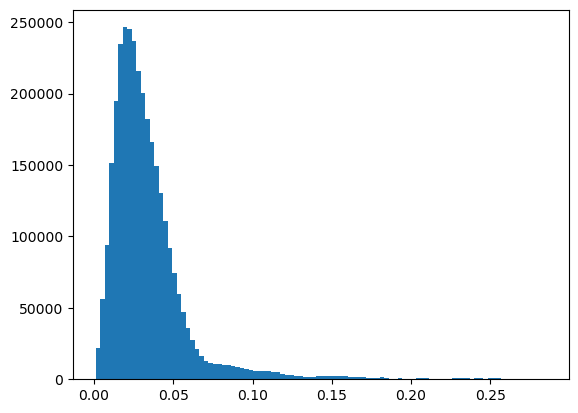

In [ ]:
df_kl_1kg["kl"].hist(bins=100)
plt.grid(False)

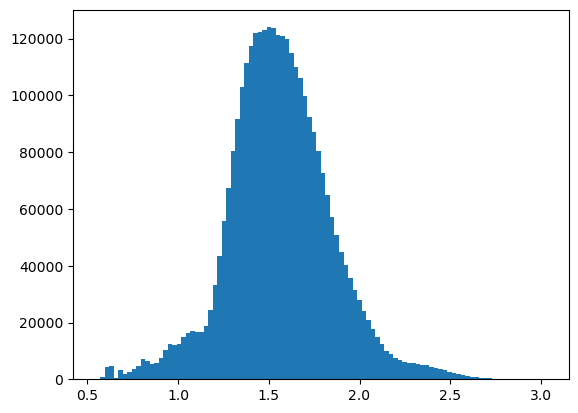

In [ ]:
df_kl_1kg["kl_neg_log10"].hist(bins=100)
plt.grid(False)

In [ ]:
# standard scale kl trans
sc = StandardScaler()
df_kl_1kg["kl_neg_log10_z"] = sc.fit_transform(
    df_kl_1kg["kl_neg_log10"].to_numpy().reshape(-1, 1)
)
df_kl_1kg.head()

,s_i,s_j,kl,kl_neg_log10,kl_neg_log10_z
0,NA18614,HG01918,0.035064,1.455137,-0.373640
1,NA18614,NA18546,0.046145,1.335876,-0.790457
2,NA18614,HG02855,0.024379,1.612991,0.178061
3,NA18614,HG03565,0.025648,1.590952,0.101034
4,NA18614,NA19324,0.022034,1.656910,0.331556


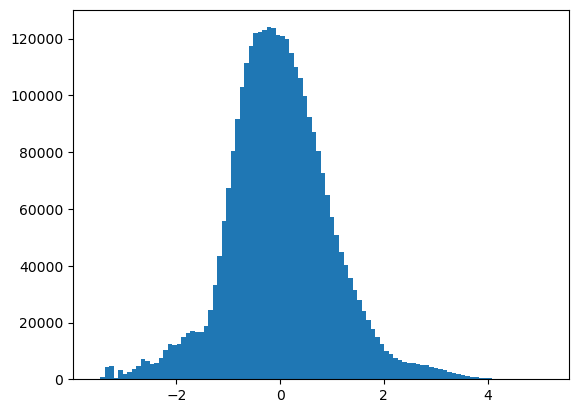

In [ ]:
df_kl_1kg["kl_neg_log10_z"].hist(bins=100)
plt.grid(False)

In [ ]:
df_kl_1kg.to_csv(
    "/data/jake/csci_7000-final_project/1kg-g2g_kl.tsv", sep="\t", index=False
)

In [ ]:
pd.read_csv("/data/jake/csci_7000-final_project/1kg-g2g_kl.tsv", sep="\t").head()

,s_i,s_j,kl,kl_trans
0,NA18614,HG01918,0.035064,1.455137
1,NA18614,NA18546,0.046145,1.335876
2,NA18614,HG02855,0.024379,1.612991
3,NA18614,HG03565,0.025648,1.590952
4,NA18614,NA19324,0.022034,1.656910


In [ ]:
df_kl_1kg.head()

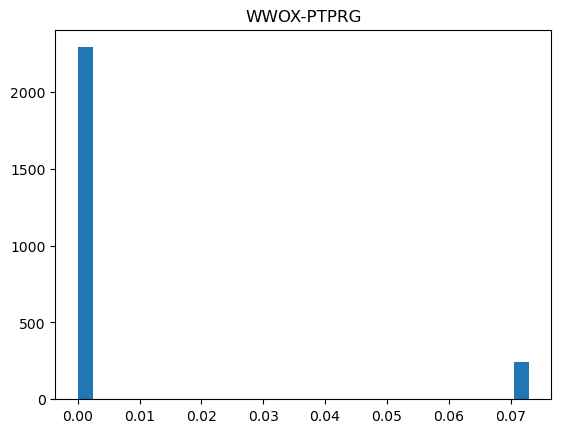

In [ ]:
# g2g features are power law distributed, concentrated around 1 (0 without smoothing)
df_vec.sample(1, axis=1).apply(lambda x: boxcox(x)[0]).hist(bins=30)
plt.grid(False)

### Pairwise L2

In [34]:
def dist_sq_l2(sample_pair, df_vec):
    s1 = df_vec.loc[sample_pair[0], :]
    s2 = df_vec.loc[sample_pair[1], :]
    return sample_pair, np.linalg.norm(s1 - s2) ** 2


dist_sq_l2(sample_pairs[0], df_vec)

(('NA18614', 'HG01918'), np.float64(2098.9999999999995))

In [ ]:
# 19 mins
# np.linalg.norm is already parallelized
l2s = []
for sp in sample_pairs:
    l2s.append(dist_sq_l2(sp, df_vec))

In [ ]:
len

In [37]:
df_l2s_1kg = pd.DataFrame(l2s, columns=["sample_pair", "l2"])
df_l2s_1kg[["s_i", "s_j"]] = pd.DataFrame(
    df_l2s_1kg["sample_pair"].tolist(), index=df_l2s_1kg.index
)
df_l2s_1kg.drop("sample_pair", axis=1, inplace=True)
df_l2s_1kg.to_csv(
    "/data/jake/csci_7000-final_project/1kg-g2g_l2.tsv", sep="\t", index=False
)

In [ ]:
# cpus = 44
# p_dist_sq_l2 = partial(dist_sq_l2, df_vec=df_vec)
# with mp.Pool(cpus) as pool:
#     l2s = pool.map(p_dist_sq_l2, sample_pairs)
# l2s[:5]

In [39]:
df_l2s_1kg.head()

,l2,s_i,s_j
0,2099.0,NA18614,HG01918
1,2988.0,NA18614,NA18546
2,1381.0,NA18614,HG02855
3,1468.0,NA18614,HG03565
4,1244.0,NA18614,NA19324


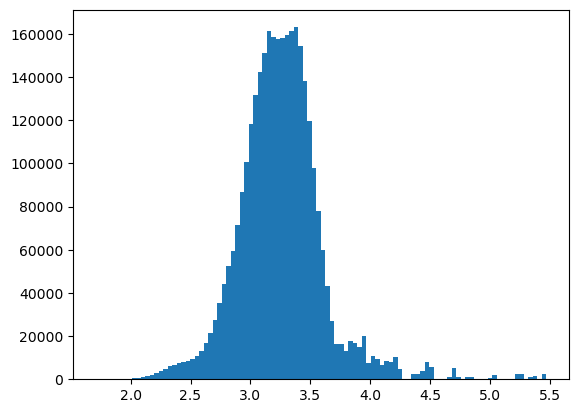

In [42]:
df_l2s_1kg["l2"].apply(lambda x: np.log10(x + 1)).hist(bins=100)
plt.grid(False)

In [44]:
df_l2s_1kg["l2_log10"] = df_l2s_1kg["l2"].apply(lambda x: np.log10(x + 1))
sc = StandardScaler()
df_l2s_1kg["l2_log10_z"] = sc.fit_transform(
    df_l2s_1kg["l2_log10"].to_numpy().reshape(-1, 1)
)
df_l2s_1kg.head()

,l2,s_i,s_j,l2_log10,l2_log10_z
0,2099.0,NA18614,HG01918,3.322219,0.179185
1,2988.0,NA18614,NA18546,3.475526,0.602122
2,1381.0,NA18614,HG02855,3.140508,-0.322113
3,1468.0,NA18614,HG03565,3.167022,-0.248968
4,1244.0,NA18614,NA19324,3.095169,-0.447192


<Axes: >

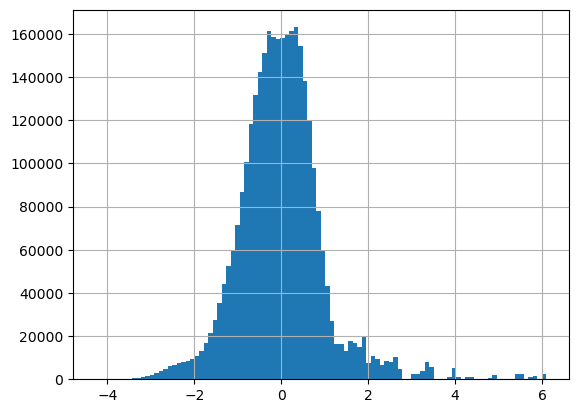

In [45]:
df_l2s_1kg["l2_log10_z"].hist(bins=100)

- Use sq l2 distance instead of D_{kl} since this compares to Johnson Lindenstrauss

## Baselines

### Johnson lindenstrauss

In [314]:
np.random.seed(0)

#### Epsilon 0.1, k 2086

In [315]:
# distortion threshold
epsilon = 0.1
# compute dimensionality
# such that the distortion is less than epsilon
n = 2500
k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
k

2086

In [316]:
jl_transformer = GaussianRandomProjection(n_components=k, random_state=0)
df_vec_transformed = pd.DataFrame(jl_transformer.fit_transform(df_vec))
print(df_vec_transformed.shape)
df_vec_transformed.index = df_vec.index
df_vec_transformed.head()

(2535, 2086)


,0,1,2,3,4,5,6,7,8,9,...,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085
NA18614,-2.051126,-1.456229,1.092002,-2.992604,5.724252,6.829133,3.691685,6.263694,6.066922,-0.738450,...,0.272980,0.782090,3.451776,2.813435,1.412871,4.385370,3.945090,-1.796855,-3.564690,-0.671526
HG01918,-4.188421,-2.929395,1.031436,-3.002698,6.823088,4.705258,4.560896,7.202094,4.654009,-2.028744,...,0.236549,2.388977,1.831683,3.435842,1.664522,3.971462,2.639332,-2.005333,-2.661582,-0.368578
NA18546,-1.617051,-2.816215,-0.656346,-1.867814,6.993427,5.637329,4.379765,7.822922,4.497582,-0.964018,...,0.792185,3.809103,3.518849,3.948816,0.977811,5.082008,2.365027,-2.099849,-2.363069,-2.201466
HG02855,-3.507558,-2.334668,1.478754,-2.366508,5.864569,5.478177,4.399189,5.801723,3.456933,-0.583059,...,1.128956,1.588741,1.296292,2.986274,1.078364,4.191972,3.878989,-1.570710,-2.510935,-0.947581
HG03565,-2.866200,-2.596682,1.888015,-2.184448,6.031157,5.951043,4.294785,5.342199,4.487081,-1.275908,...,1.151451,1.673860,2.108185,3.293141,1.698277,3.719313,3.614750,-1.794606,-2.213681,-0.841359


In [317]:
samples2 = df_vec.sample(2, random_state=0).index.tolist()
i1 = samples2[0]
i2 = samples2[1]
print(i1, i2)

HG03780 HG04054


In [ ]:
tsne_original = TSNE(n_components=2, random_state=0)
df_tsne_original = pd.DataFrame(tsne_original.fit_transform(df_vec))
df_tsne_original.index = df_vec.index

tsne_jl = TSNE(n_components=2, random_state=0)
df_tsne_jl = pd.DataFrame(tsne_jl.fit_transform(df_vec_transformed))
df_tsne_jl.index = df_vec.index

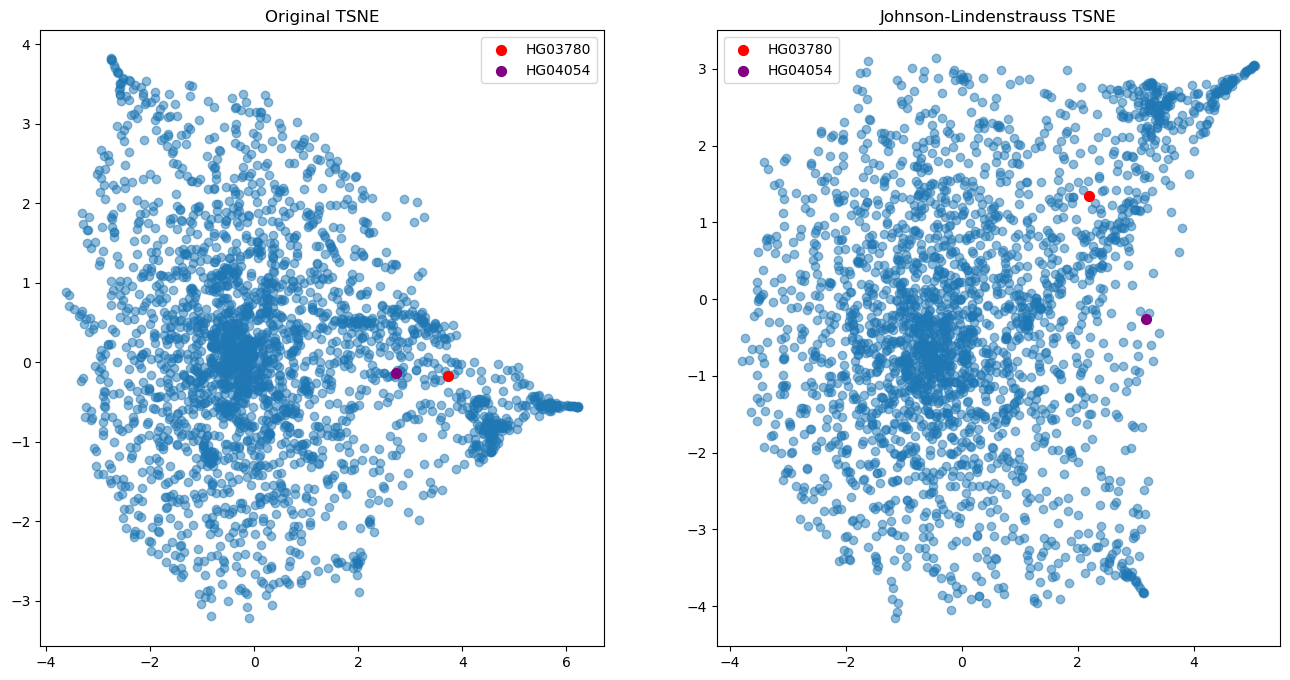

In [ ]:
# plot original and jl tsne

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].scatter(df_tsne_original.iloc[:, 0], df_tsne_original.iloc[:, 1], alpha=0.5)
axes[0].set_title("Original TSNE")
axes[0].scatter(
    df_tsne_original.loc[i1, 0],
    df_tsne_original.loc[i1, 1],
    color="red",
    s=50,
    label=i1,
)
axes[0].scatter(
    df_tsne_original.loc[i2, 0],
    df_tsne_original.loc[i2, 1],
    color="purple",
    s=50,
    label=i2,
)
axes[0].legend()
# axes[0].annotate('Point 1', (df_tsne_original.loc[i1, 0], df_tsne_original.loc[i1, 1]),
#                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# axes[0].annotate('Point 2', (df_tsne_original.loc[i2, 0], df_tsne_original.loc[i2, 1]),
#                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')

axes[1].scatter(df_tsne_jl.iloc[:, 0], df_tsne_jl.iloc[:, 1], alpha=0.5)
axes[1].set_title("Johnson-Lindenstrauss TSNE")
axes[1].scatter(
    df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1], color="red", s=50, label=i1
)
axes[1].scatter(
    df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1], color="purple", s=50, label=i2
)
axes[1].legend()
# axes[1].annotate('Point 1', (df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1]),
#                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# axes[1].annotate('Point 2', (df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1]),
#                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')

#### Epsilon 0.05, k 8346

In [46]:
# distortion threshold
epsilon = 0.05
# compute dimensionality
# such that the distortion is less than epsilon
n = 2500
k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
k

8346

In [47]:
jl_transformer = GaussianRandomProjection(n_components=k, random_state=0)
df_vec_transformed = pd.DataFrame(jl_transformer.fit_transform(df_vec))
print(df_vec_transformed.shape)
df_vec_transformed.index = df_vec.index
df_vec_transformed.head()

(2535, 8346)


,0,1,2,3,4,5,6,7,8,9,...,8336,8337,8338,8339,8340,8341,8342,8343,8344,8345
NA18614,-1.025440,-0.728027,0.545936,-1.496123,2.861783,3.414157,1.845622,3.131472,3.033098,-0.369181,...,-1.635071,1.223963,-0.595971,-0.056969,-2.027429,-0.639990,-2.978909,1.882458,2.238071,-0.215450
HG01918,-2.093960,-1.464522,0.515656,-1.501169,3.411135,2.352347,2.280175,3.600616,2.326726,-1.014250,...,-1.051927,1.456325,0.345446,0.659130,-1.802837,-0.998883,-2.960917,1.615550,1.841080,-0.453684
NA18546,-0.808429,-1.407939,-0.328134,-0.933795,3.496295,2.818327,2.189620,3.910992,2.248522,-0.481951,...,-1.712473,1.457106,0.205576,0.590039,-1.667915,-1.018123,-3.333114,1.880983,2.245409,-1.040574
HG02855,-1.753569,-1.167194,0.739288,-1.183112,2.931933,2.738760,2.199331,2.900514,1.728260,-0.291495,...,-1.019134,1.043395,0.068507,0.573139,-2.300647,-1.152485,-1.995772,1.904557,1.577608,-0.908192
HG03565,-1.432928,-1.298186,0.943894,-1.092093,3.015217,2.975165,2.147135,2.670779,2.243272,-0.637878,...,-1.145276,1.114458,0.237670,0.446908,-2.199421,-1.238291,-2.308198,1.696419,1.618725,-0.514636


In [1364]:
samples2 = df_vec.sample(2, random_state=0).index.tolist()
i1 = samples2[0]
i2 = samples2[1]
print(i1, i2)

NameError: name 'df_vec' is not defined

In [ ]:
tsne_original = TSNE(n_components=2, random_state=0)
df_tsne_original = pd.DataFrame(tsne_original.fit_transform(df_vec))
df_tsne_original.index = df_vec.index

tsne_jl = TSNE(n_components=2, random_state=0)
df_tsne_jl = pd.DataFrame(tsne_jl.fit_transform(df_vec_transformed))
df_tsne_jl.index = df_vec.index

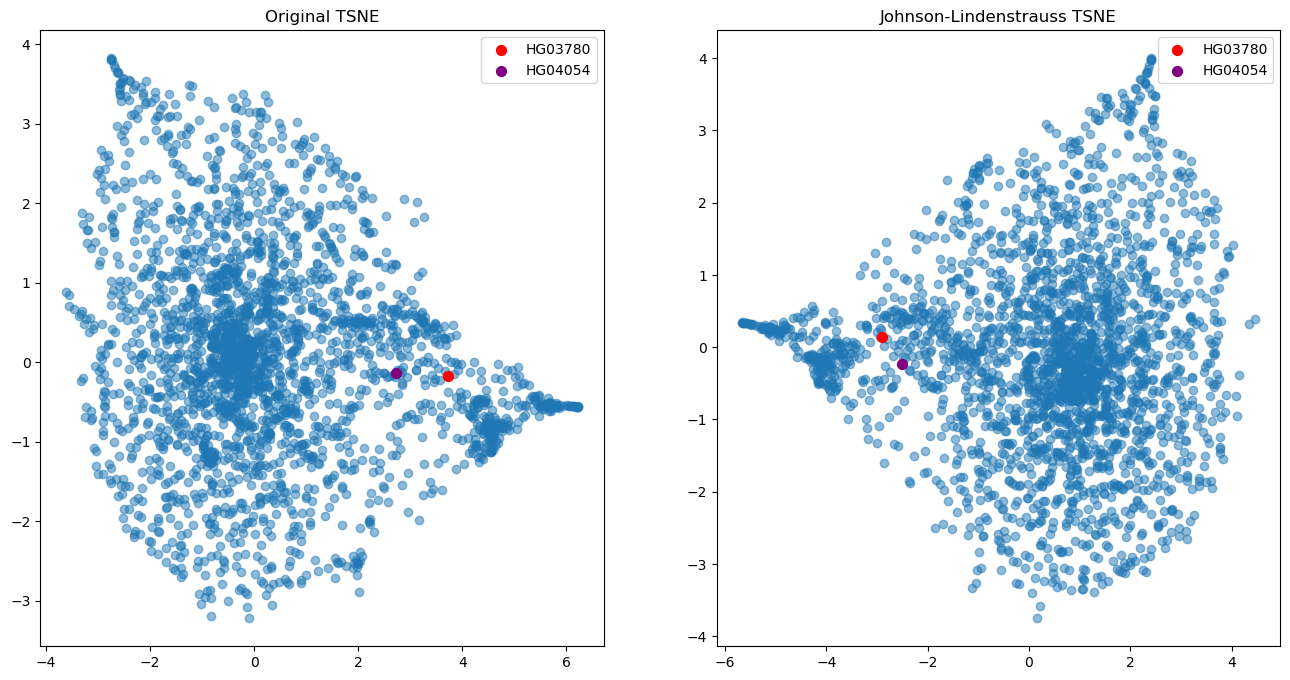

In [ ]:
# plot original and jl tsne

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].scatter(df_tsne_original.iloc[:, 0], df_tsne_original.iloc[:, 1], alpha=0.5)
axes[0].set_title("Original TSNE")
axes[0].scatter(
    df_tsne_original.loc[i1, 0],
    df_tsne_original.loc[i1, 1],
    color="red",
    s=50,
    label=i1,
)
axes[0].scatter(
    df_tsne_original.loc[i2, 0],
    df_tsne_original.loc[i2, 1],
    color="purple",
    s=50,
    label=i2,
)
axes[0].legend()
# axes[0].annotate('Point 1', (df_tsne_original.loc[i1, 0], df_tsne_original.loc[i1, 1]),
#                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# axes[0].annotate('Point 2', (df_tsne_original.loc[i2, 0], df_tsne_original.loc[i2, 1]),
#                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')

axes[1].scatter(df_tsne_jl.iloc[:, 0], df_tsne_jl.iloc[:, 1], alpha=0.5)
axes[1].set_title("Johnson-Lindenstrauss TSNE")
axes[1].scatter(
    df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1], color="red", s=50, label=i1
)
axes[1].scatter(
    df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1], color="purple", s=50, label=i2
)
axes[1].legend()
# axes[1].annotate('Point 1', (df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1]),
#                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# axes[1].annotate('Point 2', (df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1]),
#                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')

In [54]:
l2s_jl = []
i = 0
for sp in sample_pairs:
    i = i + 1
    l2s_jl.append(dist_sq_l2(sp, df_vec_transformed))

In [55]:
df_l2s_jl_1kg = pd.DataFrame(l2s_jl, columns=["sample_pair", "l2"])
df_l2s_jl_1kg[["s_i", "s_j"]] = pd.DataFrame(
    df_l2s_jl_1kg["sample_pair"].tolist(), index=df_l2s_jl_1kg.index
)
df_l2s_jl_1kg.drop("sample_pair", axis=1, inplace=True)
df_l2s_jl_1kg.to_csv(
    "/data/jake/csci_7000-final_project/1kg-g2g_l2-jl.tsv", sep="\t", index=False
)

<Axes: >

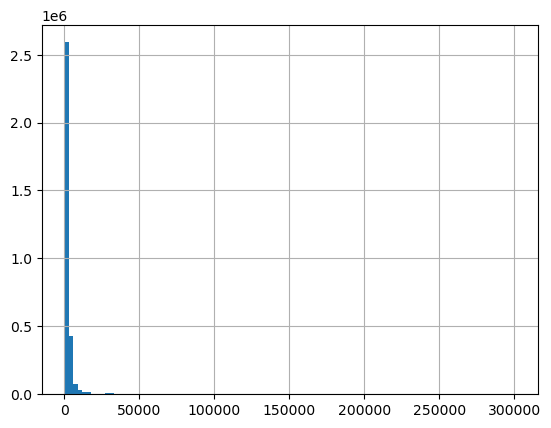

In [57]:
df_l2s_jl_1kg["l2"].hist(bins=100)

In [58]:
df_l2s_jl_1kg["l2_log10"] = df_l2s_jl_1kg["l2"].apply(lambda x: np.log10(x + 1))
sc = StandardScaler()
df_l2s_jl_1kg["l2_log10_z"] = sc.fit_transform(
    df_l2s_jl_1kg["l2_log10"].to_numpy().reshape(-1, 1)
)
df_l2s_jl_1kg.head()

,l2,s_i,s_j,l2_log10,l2_log10_z
0,2107.241560,NA18614,HG01918,3.323920,0.184040
1,2960.136977,NA18614,NA18546,3.471458,0.590671
2,1374.936231,NA18614,HG02855,3.138598,-0.326728
3,1446.922471,NA18614,HG03565,3.160745,-0.265689
4,1231.207125,NA18614,NA19324,3.090684,-0.458786


<Axes: >

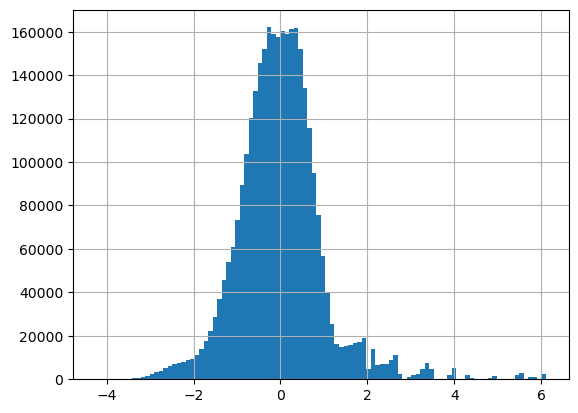

In [59]:
df_l2s_jl_1kg["l2_log10_z"].hist(bins=100)

##### MSE

In [61]:
# mse between original and jl transformed l2 distances
np.mean((df_l2s_1kg["l2_log10_z"] - df_l2s_jl_1kg["l2_log10_z"]) ** 2)

np.float64(0.00033387632630372285)

## Model data

In [3]:
df_vec = pd.read_csv(
    "/data/jake/csci_7000-final_project/1kg-g2g_vecs.tsv", sep="\t", index_col=0
)

In [4]:
print(df_vec.shape)
df_vec.head()


(2535, 18721)


,ACYP2-AFF3,ACYP2-AGAP1,ACYP2-AP000304.12,ACYP2-APP,ACYP2-ARHGAP15,ACYP2-ARHGAP6,ACYP2-BACH1,ACYP2-CACNA2D3,ACYP2-CADM2,ACYP2-CCSER1,...,ZSWIM5-TTC28,ZSWIM5-ULK4,ZSWIM5-USH2A,ZSWIM5-VAV3,ZSWIM5-WDPCP,ZSWIM5-WWOX,ZSWIM5-ZBTB20,ZSWIM5-ZNF385D,ZSWIM5-ZNF536,ZSWIM5-ZRANB3
NA18614,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG01918,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,1,1,1,1,1,2
NA18546,1,1,1,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG02855,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
HG03565,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,2,1,1,1,1,1


In [12]:
math.comb(2535,2)

3211845

In [5]:
df_l2s_1kg = pd.read_csv(
    "/data/jake/csci_7000-final_project/1kg-g2g_l2.tsv", sep="\t"
)

In [6]:
print(df_l2s_1kg.shape)
df_l2s_1kg.head()

(3211845, 3)


,l2,s_i,s_j
0,2099.0,NA18614,HG01918
1,2988.0,NA18614,NA18546
2,1381.0,NA18614,HG02855
3,1468.0,NA18614,HG03565
4,1244.0,NA18614,NA19324


In [7]:
df_l2s_1kg['l2'] = df_l2s_1kg['l2'].apply(lambda x: np.log10(x + 1))
df_l2s_1kg['l2'] = StandardScaler().fit_transform(df_l2s_1kg['l2'].to_numpy().reshape(-1,1))
df_l2s_1kg.head()

,l2,s_i,s_j
0,0.179185,NA18614,HG01918
1,0.602122,NA18614,NA18546
2,-0.322113,NA18614,HG02855
3,-0.248968,NA18614,HG03565
4,-0.447192,NA18614,NA19324


Pseudocode

- Define pairs
- Assign targets
- Split pairs

In [8]:
pairs = df_l2s_1kg[["s_i", "s_j"]]
pairs["target"] = df_l2s_1kg.loc[:,"l2"].astype(np.float32)
pairs.head()

,s_i,s_j,target
0,NA18614,HG01918,0.179185
1,NA18614,NA18546,0.602122
2,NA18614,HG02855,-0.322113
3,NA18614,HG03565,-0.248968
4,NA18614,NA19324,-0.447192


<Axes: >

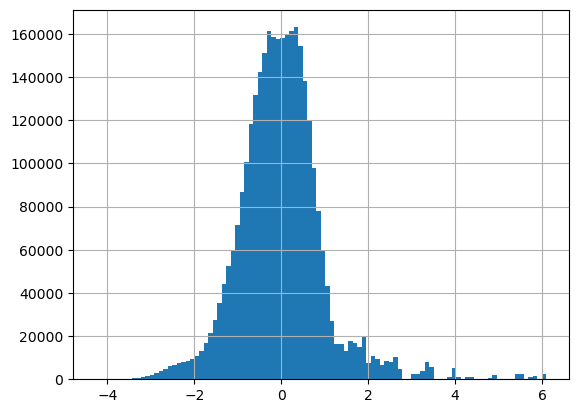

In [9]:
pairs["target"].hist(bins=100)

In [95]:
d_tensor = {i: torch.tensor(row, dtype=torch.int32) for i, row in df_vec.iterrows()}
list(d_tensor.items())[:5]

/tmp/ipykernel_1762980/336671863.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d_tensor = {i: torch.tensor(row, dtype=torch.int32) for i, row in df_vec.iterrows()}


[('NA18614', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)),
 ('HG01918', tensor([1, 1, 1,  ..., 1, 1, 2], dtype=torch.int32)),
 ('NA18546', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)),
 ('HG02855', tensor([1, 1, 1,  ..., 1, 2, 1], dtype=torch.int32)),
 ('HG03565', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32))]

In [124]:
torch.save(d_tensor, "/data/jake/csci_7000-final_project/1kg-g2g-tensors.pt")

In [126]:
d_tensor = torch.load("/data/jake/csci_7000-final_project/1kg-g2g-tensors.pt")
list(d_tensor.items())[:5]

/tmp/ipykernel_1762980/2140204705.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d_tensor = torch.load("/data/jake/csci_7000-final_project/1kg-g2g-tensors.pt")


[('NA18614', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)),
 ('HG01918', tensor([1, 1, 1,  ..., 1, 1, 2], dtype=torch.int32)),
 ('NA18546', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)),
 ('HG02855', tensor([1, 1, 1,  ..., 1, 2, 1], dtype=torch.int32)),
 ('HG03565', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32))]

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, d_tensor, df_target):
        self.d_tensor = d_tensor
        self.df_target = df_target

    def __len__(self):
        return len(self.d_tensor.items())

    def __getitem__(self, idx):
        pair = self.df_target.sample(1)
        s1 = pair["s_i"].values[0]
        t1 = self.d_tensor[s1]
        s2 = pair["s_j"].values[0]
        t2 = self.d_tensor[s2]
        target = torch.tensor(pair["target"].values[0], dtype=torch.float32)

        return idx, {"s1": s1, "x1": t1, "s2": s2, "x2": t2, "target": target}

In [135]:
dataset = SiameseDataset(d_tensor, pairs)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
print(len(dataset), len(dataloader))

# note: handle return values differently when batch size is >1
for i, data in dataloader:
    print(i)
    s1 = data["s1"]
    x1 = data["x1"]
    s2 = data["s2"]
    x2 = data["x2"]
    target = data["target"]
    print(s1, x1, s2, x2, target)
    break

2535 2535
tensor([0])
['HG02360'] tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32) ['HG01077'] tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32) tensor([0.2212])


{'s1': ['HG02360'],
 'x1': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32),
 's2': ['HG01077'],
 'x2': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32),
 'target': tensor([0.2212])}

In [137]:
dataset = SiameseDataset(d_tensor, pairs)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)
print(len(dataset), len(dataloader))
for i, data in dataloader:
    print(i)
    print(data)
    break

2535 1268
tensor([0, 1])
{'s1': ['HG01121', 'HG04188'], 'x1': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32), 's2': ['HG01311', 'NA18881'], 'x2': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32), 'target': tensor([-1.6401, -0.0290])}


In [139]:
# batch_size > 2 automatically converts dict values to list/tensor
data

{'s1': ['HG01121', 'HG04188'],
 'x1': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32),
 's2': ['HG01311', 'NA18881'],
 'x2': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32),
 'target': tensor([-1.6401, -0.0290])}

## PCAWG vectors and targets

In [54]:
# all 1kg giggle files
giggle_pcawg = "/data/jake/genefusion/data/2024_11_10-fusions-pcawg-combined/giggle_cln2"
os.listdir(giggle_pcawg)[:5]

['1.pos.CCDC28B.32665987.32670988.giggle',
 '2.pos.AC074117.10.27579113.27590489.giggle',
 '3.pos.CRELD1.9975506.9987097.giggle',
 '1.neg.IVNS1ABP.185265520.185286461.giggle',
 '16.neg.NPIPB7.28467693.28481868.giggle']

In [55]:
df_genes = pd.read_csv("./csci_7000-genes.tsv", sep="\t", header=None)
df_genes.columns = ["gene1", "gene2"]
df_genes.head()

,gene1,gene2
0,TNRC6B,LRP1B
1,TNRC6B,ASH1L
2,TNRC6B,IQCJnegSCHIP1
3,TNRC6B,CACNA1E
4,TNRC6B,KIAA1671


In [56]:
genes = set(pd.concat([df_genes["gene1"], df_genes["gene2"]]).unique())

In [57]:
def filestring2data(string):
    # assumes .giggle extension
    chrm = string.split(".")[0]
    strand = string.split(".")[1]
    gene = string.split(".")[2]
    start = string.split(".")[-3]
    end = string.split(".")[-2]
    # handle rare case where gene name has a period
    if len(string.split(".")) >= 7:
        gene = ".".join(string.split(".")[2:-3])
    return [chrm, strand, gene, start, end]

In [58]:
filestring2data("21.neg.AP000304.12.34956993.35284635.giggle")

['21', 'neg', 'AP000304.12', '34956993', '35284635']

### Gene giggles

In [60]:
# map genes to giggle files
fmap_pcawg = {k: None for k in genes}
for f in os.listdir(giggle_pcawg):
    _, _, gene, _, _ = filestring2data(f)
    if gene in fmap_pcawg.keys():
        fmap_pcawg[gene] = f

In [61]:
df_fmap_pcawg = pd.DataFrame(list(fmap_pcawg.items()), columns=["gene", "file"])
df_fmap_pcawg.head()

,gene,file
0,HHAT,1.pos.HHAT.210501596.210849638.giggle
1,OSBP2,22.pos.OSBP2.31089769.31303811.giggle
2,INADL,1.pos.INADL.62208149.62629592.giggle
3,MAST2,1.pos.MAST2.46252659.46501796.giggle
4,LIPEnegAS1,19.pos.LIPEnegAS1.42901280.43156507.giggle


In [ ]:
df_giggle = pd.read_csv(
    os.path.join(giggle_pcawg, df_fmap_pcawg["file"][0]), sep="\t", header=None
)
giggle_columns = [
    "l_chrm",
    "l_start",
    "l_end",
    "strand",
    "r_chrm",
    "r_start",
    "r_end",
    "strand",
    "unknown",
    "sample",
]
df_giggle.columns = giggle_columns
df_giggle.head()

,l_chrm,l_start,l_end,strand,r_chrm,r_start,r_end,strand,unknown,sample
0,1,210501580,210501601,-1,6,135158703,135158758,-1,1,beds/FI10093.excord.bed.gz
1,1,210501592,210501693,1,5,14838940,14838940,1,0,beds/FI10093.excord.bed.gz
2,1,210501657,210501657,1,1,210502442,210502543,-1,0,beds/FI10093.excord.bed.gz
3,1,210501693,210501693,1,1,210502389,210502490,-1,0,beds/FI10093.excord.bed.gz
4,1,210501695,210501695,-1,11,2119935,2119955,-1,-1,beds/FI10093.excord.bed.gz


In [64]:
del df_giggle

In [66]:
# read giggle if not empty
def read_giggle(path):
    # handle empty file case for lexicographically high ranked files
    # which are often right intervals
    # thus, no giggle hits when it is query/source
    if not (os.path.getsize(path) == 0):
        df = pd.read_csv(path, sep="\t", header=None)
        df.columns = [
            "l_chrm",
            "l_start",
            "l_end",
            "strand",
            "r_chrm",
            "r_start",
            "r_end",
            "strand",
            "unknown",
            "sample",
        ]
        return df
    else:
        return None


df_giggle = read_giggle(os.path.join(giggle_pcawg, df_fmap_pcawg["file"][0]))
df_giggle.head()

,l_chrm,l_start,l_end,strand,r_chrm,r_start,r_end,strand,unknown,sample
0,1,210501580,210501601,-1,6,135158703,135158758,-1,1,beds/FI10093.excord.bed.gz
1,1,210501592,210501693,1,5,14838940,14838940,1,0,beds/FI10093.excord.bed.gz
2,1,210501657,210501657,1,1,210502442,210502543,-1,0,beds/FI10093.excord.bed.gz
3,1,210501693,210501693,1,1,210502389,210502490,-1,0,beds/FI10093.excord.bed.gz
4,1,210501695,210501695,-1,11,2119935,2119955,-1,-1,beds/FI10093.excord.bed.gz


In [67]:
del df_giggle

In [68]:
def write_giggle(df, path, mode="w"):
    df.to_csv(path, sep="\t", index=False, header=False, mode=mode)

### Sample-wise giggle

In [ ]:
def split_giggle_samples(file, dirgiggle, dirout):
    gene = filestring2data(file)[2]
    path = os.path.join(dirgiggle, file)
    df_giggle = read_giggle(path)
    if type(df_giggle) != type(None):
        df_giggle["sample"] = df_giggle["sample"].apply(
            lambda x: os.path.basename(x).split(".")[0]
        )
        # print(df_giggle['sample'])
        for sample, group in df_giggle.groupby("sample"):
            write_giggle(group, os.path.join(dirout, f"{sample}.{gene}.tsv"), mode="w")

# runtime: 2min 

# files = list(df_fmap_pcawg["file"])
# cpus = 50
# p_split_giggle_samples = partial(
#     split_giggle_samples,
#     dirgiggle=giggle_pcawg,
#     dirout="/data/jake/csci_7000-final_project/samples_pcawg/giggle"
# )
# with mp.Pool(cpus) as pool:
#     pool.map(p_split_giggle_samples, files)

/tmp/ipykernel_1768370/2074879502.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep="\t", header=None)
/tmp/ipykernel_1768370/2074879502.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep="\t", header=None)
/tmp/ipykernel_1768370/2074879502.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep="\t", header=None)
/tmp/ipykernel_1768370/2074879502.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep="\t", header=None)


- Runtime: <1 min
- Do intersect for gene2gene variants
    - `genefile='/data/jake/genefusion/data/gene_file_cln.txt'`
    - `outdir='/data/jake/csci_7000-final_project/samples_pcawg/gene2gene'`
    - `bedtools='/data/jake/bedtools.static.binary'`
    - `ls | gargs --log ../gargs.log -p 64 -o "$bedtools intersect -a $genefile -b <(cut -f 5-7 {0}) > $outdir/{0}.g2g"`

In [85]:
def read_gene2gene(file):
    df = pd.read_csv(file, sep="\t", header=None, usecols=[3])
    df.columns = ["target"]
    return df

### Location

In [71]:
gene_file = "/data/jake/genefusion/data/gene_file_cln.txt"
df_gene_file = pd.read_csv(gene_file, sep="\t", header=None)
df_gene_file.columns = ["chrm", "start", "end", "gene", "strand"]
df_gene_file.head()

,chrm,start,end,gene,strand
0,1,69091,70008,OR4F5,pos
1,1,134901,139379,AL627309.1,neg
2,1,139790,140339,RP11neg34P13.14,neg
3,1,367640,368634,OR4F29,pos
4,1,621059,622053,OR4F16,neg


In [72]:
# subset
mask = df_gene_file["gene"].apply(lambda x: x in genes)
df_gene_file = df_gene_file[mask]
df_gene_file.head()

,chrm,start,end,gene,strand
145,1,6845384,7829766,CAMTA1,pos
159,1,8412457,8877702,RERE,neg
227,1,12290124,12572099,VPS13D,pos
261,1,14925200,15444539,KAZN,pos
308,1,17066768,17299474,CROCC,pos


- the gene file is already lexicographically sorted for chromosomes
- a second and thrid level sorts by start and end coordinates

In [73]:
g2g_comb = list(itertools.combinations(df_gene_file["gene"].tolist(), 2))
g2g_comb = pd.DataFrame(g2g_comb)
g2g_comb.columns = ["source", "target"]
g2g_comb

,source,target
0,CAMTA1,RERE
1,CAMTA1,VPS13D
2,CAMTA1,KAZN
3,CAMTA1,CROCC
4,CAMTA1,EIF4G3
...,...,...
18716,ARHGAP6,IL1RAPL1
18717,ARHGAP6,DMD
18718,FRMPD4,IL1RAPL1
18719,FRMPD4,DMD


### Vectorize samples

In [78]:
dir_g2g_pcawg = "/data/jake/csci_7000-final_project/samples_pcawg/gene2gene"
os.listdir(dir_g2g_pcawg)[:5]

['FI26317.TNRC6B.tsv.g2g',
 'FI22889.LRRTM4.tsv.g2g',
 'FI45246.TASP1.tsv.g2g',
 'FI19114.PDE11A.tsv.g2g',
 'FI45994.MICAL3.tsv.g2g']

In [79]:
def init_vector(g2g_comb):
    return pd.Series(
        np.zeros(g2g_comb.shape[0], dtype=np.int64),
        index=g2g_comb.apply(lambda row: f"{row['source']}-{row['target']}", axis=1),
    )


init_vector(g2g_comb)

CAMTA1-RERE         0
CAMTA1-VPS13D       0
CAMTA1-KAZN         0
CAMTA1-CROCC        0
CAMTA1-EIF4G3       0
                   ..
ARHGAP6-IL1RAPL1    0
ARHGAP6-DMD         0
FRMPD4-IL1RAPL1     0
FRMPD4-DMD          0
IL1RAPL1-DMD        0
Length: 18721, dtype: int64

In [86]:
def sample2vec(sample, dir_g2g, smooth=False):
    pattern = rf"^{sample}."
    files = [i for i in os.listdir(dir_g2g) if re.search(pattern, i)]
    v = init_vector(g2g_comb)
    v.name = sample
    for file in files:
        # handle case where gene name includes periods
        path = os.path.join(dir_g2g, file)
        if not (os.stat(path).st_size == 0):
            gene = "".join(file.split(".")[1:-2])
            if gene not in genes:
                continue
            df = read_gene2gene(path)
            for i, row in df.iterrows():
                target = row["target"]
                if (target in genes) and (gene != target):
                    if f"{gene}-{target}" in v.index:
                        v[f"{gene}-{target}"] += 1
                    elif f"{target}-{gene}" in v.index:
                        v[f"{target}-{gene}"] += 1
                    else:
                        raise ValueError(
                            f"Gene pair {gene}-{target} not in vector index"
                        )
    v.sort_index(inplace=True)
    if smooth:
        v = v.apply(lambda x: x + 1)
    return v

v = sample2vec("NA19394", dir_g2g_pcawg, smooth=True)
v.head()

ACYP2-AFF3           1
ACYP2-AGAP1          1
ACYP2-AP000304.12    1
ACYP2-APP            1
ACYP2-ARHGAP15       1
Name: NA19394, dtype: int64

In [83]:
samples = [i.split(".")[0] for i in os.listdir(dir_g2g_pcawg)]
samples = pd.Series(samples).unique().tolist()
print(len(samples))
samples[:5]

142


['FI26317', 'FI22889', 'FI45246', 'FI19114', 'FI45994']

In [ ]:
# runtime: 20 minutes
# parallelization does not help much
# the high coverage of PCAWG means the GIGGLE files are much larger than in 1kg

# cpus = 50
# p_sample2vec = partial(sample2vec, dir_g2g=dir_g2g_pcawg, smooth=True)
# with mp.Pool(cpus) as pool:
#     vecs = pool.map(p_sample2vec, samples)

- Note: smoothing is not necessary since I'm no longer using $D_{kl}$ as ground truth. 

Instead, we normalize sample-wise before using the model: $s:= sum, v' := v/ s$

In [88]:
df_vec_pcawg = pd.concat(vecs, axis=1).T
df_vec_pcawg

,ACYP2-AFF3,ACYP2-AGAP1,ACYP2-AP000304.12,ACYP2-APP,ACYP2-ARHGAP15,ACYP2-ARHGAP6,ACYP2-BACH1,ACYP2-CACNA2D3,ACYP2-CADM2,ACYP2-CCSER1,...,ZSWIM5-TTC28,ZSWIM5-ULK4,ZSWIM5-USH2A,ZSWIM5-VAV3,ZSWIM5-WDPCP,ZSWIM5-WWOX,ZSWIM5-ZBTB20,ZSWIM5-ZNF385D,ZSWIM5-ZNF536,ZSWIM5-ZRANB3
FI26317,1,6,6,2,7,5,3,7,7,16,...,9,2,4,3,1,18,7,8,2,1
FI22889,10,12,5,12,2,7,3,5,3,16,...,5,2,9,3,8,5,1,9,2,1
FI45246,12,11,8,1,2,6,4,10,8,8,...,6,12,6,1,4,7,7,19,8,1
FI19114,7,9,10,10,6,4,6,33,17,14,...,11,11,6,7,5,10,10,7,9,5
FI45994,3,5,1,4,1,1,1,1,3,4,...,2,1,1,1,1,7,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FI46611,7,6,4,3,6,1,6,4,8,11,...,2,1,3,5,3,1,1,12,2,2
FI48685,13,5,4,6,3,8,7,5,5,7,...,2,5,4,1,2,2,3,6,2,4
FI25835,8,4,4,2,1,1,2,1,4,5,...,2,10,2,6,4,10,6,9,6,2
FI38572,9,15,9,2,14,4,24,9,19,18,...,13,6,6,5,16,18,5,12,10,6


In [89]:
df_vec_pcawg.to_csv("/data/jake/csci_7000-final_project/pcawg-g2g_vecs.tsv", sep="\t")

### Pairwise L2

In [90]:
# get all combinations of sample pairs
sample_pairs = list(itertools.combinations(samples, 2))
print(len(sample_pairs))
sample_pairs[:2]

10011


[('FI26317', 'FI22889'), ('FI26317', 'FI45246')]

In [91]:
def dist_sq_l2(sample_pair, df_vec):
    s1 = df_vec.loc[sample_pair[0], :]
    s2 = df_vec.loc[sample_pair[1], :]
    return sample_pair, np.linalg.norm(s1 - s2) ** 2


dist_sq_l2(sample_pairs[0], df_vec_pcawg)

(('FI26317', 'FI22889'), np.float64(1632898.9999999998))

In [ ]:
l2s = []
for sp in sample_pairs:
    l2s.append(dist_sq_l2(sp, df_vec_pcawg))

In [95]:
df_l2s_pcawg = pd.DataFrame(l2s, columns=["sample_pair", "l2"])
df_l2s_pcawg[["s_i", "s_j"]] = pd.DataFrame(
    df_l2s_pcawg["sample_pair"].tolist(), index=df_l2s_pcawg.index
)
df_l2s_pcawg.drop("sample_pair", axis=1, inplace=True)
df_l2s_pcawg.to_csv(
    "/data/jake/csci_7000-final_project/pcawg-g2g_l2.tsv", sep="\t", index=False
)

<Axes: >

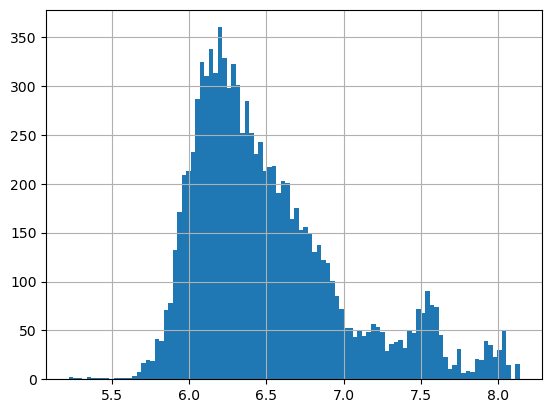

In [99]:
df_l2s_pcawg["l2"].apply(lambda x: np.log10(x+1)).hist(bins=100)

### Tensors

In [100]:
# float32 required for pytorch
d_tensor = {i: torch.tensor(row, dtype=torch.float32) for i, row in df_vec_pcawg.iterrows()}
list(d_tensor.items())[:5]

/tmp/ipykernel_1768370/1133518437.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d_tensor = {i: torch.tensor(row, dtype=torch.float32) for i, row in df_vec_pcawg.iterrows()}


[('FI26317', tensor([1., 6., 6.,  ..., 8., 2., 1.])),
 ('FI22889', tensor([10., 12.,  5.,  ...,  9.,  2.,  1.])),
 ('FI45246', tensor([12., 11.,  8.,  ..., 19.,  8.,  1.])),
 ('FI19114', tensor([ 7.,  9., 10.,  ...,  7.,  9.,  5.])),
 ('FI45994', tensor([3., 5., 1.,  ..., 1., 1., 1.]))]

In [101]:
torch.save(d_tensor, "/data/jake/csci_7000-final_project/pcawg-g2g-tensors.pt")